In [2]:
% matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from collections import namedtuple
import heapq
import seaborn as sns

from market import SimulationClock
from market import Exchange

In [3]:
def bgt_scheduler( clock, FV, p_flex, lam, order_size_bound, trader):
    order_type = 0
    delta_t = np.random.exponential(lam)
    quantity = np.random.randint(1,order_size_bound+1)*np.random.choice([-1,1])
    price = FV + np.random.randint(-p_flex,p_flex+1)
    heapq.heappush(event_queue,[clock.time+delta_t, price,quantity,trader,order_type])

def mm_scheduler(a1, a2, a3, b1, b2, b3, c1, c2, c3, d1, d2, d3, clock, lam, ba, bb, lastprice, depth, trader):
    order_type = 0
    delta_t = np.random.exponential(lam)
    if lastprice >= ba:
        quantity = a1*(lastprice - ba) + b1*depth
        price = c1*lastprice + d1*depth
    elif lastprice < bb:
        quantity = a2*(lastprice - bb) - b2*depth
        price = c2*lastprice + d2*depth
    else:
        quantity = 0
        price = c3*lastprice + d3*depth
    
    heapq.heappush(event_queue,[clock.time+delta_t, price, quantity, trader, order_type])
    pass

def mm1_scheduler(clock, e1, f1, ba, bb, trader):
    order_type = 0
    lam = e1
    delta_t = np.random.exponential(lam)
    buy_sell_sign = np.random.choice([-1,1])
    if buy_sell_sign > 0:
        price = bb
        quantity = buy_sell_sign*f1
    else:
        price = ba
        quantity = buy_sell_sign*f1
    
    heapq.heappush(event_queue,[clock.time+delta_t, price, quantity, trader, order_type])
    pass



In [5]:
generations = 10
population = 100
selection = 10
n_params = 2
mutation_rate = 0.5

# simple order generation

sim_duration = 30
burn_in = 10

events = []
FVs = []
clk = SimulationClock()
exch = Exchange(clk)
BAs = []
BBs = []
t=0

order_size_bound = 10
FV = 10
p_flex = 3
p_reset = 0.01
lam_bgt = 0.5
lam_mm = 0.5

event_queue = []

#init
for trader in range(0,10):
    bgt_scheduler(clk, FV, p_flex, lam_bgt, order_size_bound, trader)



#burn_in
while clk.time < burn_in:
    # execute next event
    event = heapq.heappop(event_queue)
    event_time, price, quantity, trader, order_type = event
    clk.time = event_time
    exch.post(price, quantity, trader, order_type)
    # reset FV
    if np.random.rand(1) < p_reset:
        FV = price
    # schedule new event
    bgt_scheduler(clk, FV, p_flex, lam_bgt, order_size_bound, trader)
    
    # stats
    events.append([clk.time,event[2],event[1]]) 
    FVs.append(FV)
    ba = exch.get_best_ask()
    bb = exch.get_best_bid()
    if ba == None:
        ba_price = 0
    else:
        ba_price = ba.price
    if bb == None:
        bb_price = 0
    else:
        bb_price = -bb.price
    BAs.append(ba_price)
    BBs.append(bb_price)

depth = BAs[-1] - BAs[-2] - BBs[-1] + BBs[-2]

a1 = np.random.uniform(0,2,100)
a2 = np.random.uniform(0,2,100)
a3 = np.random.uniform(0,2,100)
b1 = np.random.uniform(0,2,100)
b2 = np.random.uniform(0,2,100)
b3 = np.random.uniform(0,2,100)
c1 = np.random.uniform(0,2,100)
c2 = np.random.uniform(0,2,100)
c3 = np.random.uniform(0,2,100)
d1 = np.random.uniform(0,2,100)
d2 = np.random.uniform(0,2,100)
d3 = np.random.uniform(0,2,100)
e1 = np.random.uniform(0,1,100)
f1 = np.random.uniform(0,10,100)

#running
# for trader in range(10,110):
#     k = trader - 10
#     mm_scheduler(a1[k], a2[k],a3[k], b1[k], b2[k], b3[k], c1[k], c2[k], c3[k], d1[k], d2[k], d3[k], clk, lam_mm, BAs[-1], BBs[-1], exch.lastprice, depth, trader)

for trader in range(10,110):
    k = trader - 10
    mm1_scheduler(clk, e1[k], f1[k], BAs[-1], BBs[-1], trader)

while clk.time < sim_duration:
    # execute next event
    event = heapq.heappop(event_queue)
    event_time, price, quantity, trader, order_type = event
    clk.time = event_time
    exch.post(price, quantity, trader, order_type)
    # reset FV
    if np.random.rand(1) < p_reset:
        FV = price

    # stats
    events.append([clk.time,event[2],event[1]]) 
    FVs.append(FV)
    ba = exch.get_best_ask()
    bb = exch.get_best_bid()
    if ba == None:
        ba_price = 0
    else:
        ba_price = ba.price
    if bb == None:
        bb_price = 0
    else:
        bb_price = -bb.price
    BAs.append(ba_price)
    BBs.append(bb_price)
    
    depth = BAs[-1] - BAs[-2] - BBs[-1] + BBs[-2]

    # schedule new event
#     if trader >= 10:
#         k = trader - 10
#         mm_scheduler(a1[k], a2[k],a3[k], b1[k], b2[k], b3[k], c1[k], c2[k], c3[k], d1[k], d2[k], d3[k], clk, lam_mm, BAs[-1], BBs[-1], exch.lastprice, depth, trader)
    if trader >= 10:
        k = trader - 10
        mm1_scheduler(clk, e1[k], f1[k], BAs[-1], BBs[-1], trader)        
    else:
        bgt_scheduler(clk, FV, p_flex, lam_bgt, order_size_bound, trader)

In [6]:
# profit calculation
trades = np.array(exch.trades)
profit=[]
for i in range(10,110):
    profit.append(-sum(trades[trades[:,4]==i][:,3]*trades[trades[:,4]==i][:,6]*trades[trades[:,4]==i][:,2]) 
                  + sum(trades[trades[:,5]==i][:,3]*trades[trades[:,5]==i][:,6]*trades[trades[:,5]==i][:,2])
                  + (sum(trades[trades[:,4]==i][:,3]*trades[trades[:,4]==i][:,6])
                  - sum(trades[trades[:,5]==i][:,3]*trades[trades[:,5]==i][:,6]))*exch.lastprice)
profit


[0,
 0,
 8.3134165490405,
 7.105427357601002e-15,
 0,
 15.797751705366657,
 0,
 0,
 0,
 0.0,
 7.105427357601002e-15,
 0.0,
 0,
 0.0,
 0.39074103893552814,
 4.6553556426532055,
 5.181646596168651,
 0,
 2.419280914861467,
 4.728029489962424,
 7.550315460813273,
 11.631755817272904,
 8.247012710773163,
 3.966366470483951,
 7.105427357601002e-15,
 0,
 0,
 0.0,
 1.4105537623594202,
 0,
 13.976547834927096,
 8.899049253376106,
 5.220667060017604,
 9.4445697087246,
 0,
 1.5244416303050468,
 8.099042375622474,
 1.8525902839401809,
 0,
 0,
 0,
 2.038845653135491,
 8.523573811981109,
 6.696694072097216,
 0,
 0.0,
 2.335069661762951,
 228.77017463652174,
 7.105427357601002e-15,
 2.958755789905382,
 5.27989149325483,
 0.009200328063949659,
 0,
 0,
 0.3695453571297582,
 1.6445120757854426,
 3.552713678800501e-15,
 0,
 3.416507230165987,
 0,
 0,
 2.6930070518704525,
 6.432756721776585,
 0.3568394545134215,
 9.74787866834528,
 0.0,
 4.106560381777381,
 34.84047326529378,
 0,
 7.105427357601002e-15,
 

In [128]:
trades = np.array(exch.trades)
#exch.trades

In [129]:
events = np.array(events)

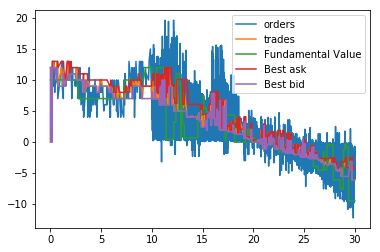

In [130]:
plt.plot(events[:,0],events[:,2], label = 'orders')
plt.plot(trades[:,0],trades[:,2], label = 'trades')
plt.plot(events[:,0],FVs, label = 'Fundamental Value')
plt.plot(events[:,0],BAs, label = 'Best ask')
plt.plot(events[:,0],BBs, label = 'Best bid')
plt.legend()

In [131]:
#list(zip(BAs,BBs))
#np.sort(np.array(exch.bids,dtype = [('price', int), ('t', float), ('quantity', int), ('trader', int), ('order_type', int)]),order=['price','t'])
#np.sort(np.array(exch.asks,dtype = [('price', int), ('t', float), ('quantity', int), ('trader', int), ('order_type', int)]),order=['price','t'])
#len(events)